<a href="https://colab.research.google.com/github/Daimond92/analisis-tienda-data-science/blob/develop/ChallengeAlura.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importación de datos



In [1]:
import pandas as pd

url = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_1%20.csv"
url2 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_2.csv"
url3 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_3.csv"
url4 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_4.csv"

tienda = pd.read_csv(url)
tienda2 = pd.read_csv(url2)
tienda3 = pd.read_csv(url3)
tienda4 = pd.read_csv(url4)

tienda.head()

,Producto,Categoría del Producto,Precio,Costo de envío,Fecha de Compra,Vendedor,Lugar de Compra,Calificación,Método de pago,Cantidad de cuotas,lat,lon
0,Asistente virtual,Electrónicos,164300.0,6900.0,16/01/2021,Pedro Gomez,Bogotá,4,Tarjeta de crédito,8,4.60971,-74.08175
1,Mesa de comedor,Muebles,192300.0,8400.0,18/05/2022,Beatriz Morales,Medellín,1,Tarjeta de crédito,4,6.25184,-75.56359
2,Juego de mesa,Juguetes,209600.0,15900.0,15/03/2021,Juan Fernandez,Cartagena,1,Tarjeta de crédito,1,10.39972,-75.51444
3,Microondas,Electrodomésticos,757500.0,41000.0,03/05/2022,Juan Fernandez,Cali,4,Nequi,1,3.43722,-76.52250
4,Silla de oficina,Muebles,335200.0,20200.0,07/11/2020,Maria Alfonso,Medellín,5,Nequi,1,6.25184,-75.56359


# Importaciones

In [58]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib import colormaps as cm
import matplotlib.markers as mmarkers

#1. Análisis de facturación



In [3]:
# Inicializar SparkSession
spark = SparkSession.builder.appName("UnirDesdePandas").getOrCreate()

#Crear la columna de Tienda
tienda_spark = spark.createDataFrame(tienda).withColumn("Tienda", lit(1))
tienda2_spark = spark.createDataFrame(tienda2).withColumn("Tienda", lit(2))
tienda3_spark = spark.createDataFrame(tienda3).withColumn("Tienda", lit(3))
tienda4_spark = spark.createDataFrame(tienda4).withColumn("Tienda", lit(4))

#Unir los dataframe
df_unido_spark = tienda_spark.unionByName(tienda2_spark, allowMissingColumns=True)
df_unido_spark = df_unido_spark.unionByName(tienda3_spark, allowMissingColumns=True)
df_unido_spark = df_unido_spark.unionByName(tienda4_spark, allowMissingColumns=True)

#Datadrame nuevamente en panda
df_pandas = df_unido_spark.toPandas()

In [4]:
df_pandas.head()

,Producto,Categoría del Producto,Precio,Costo de envío,Fecha de Compra,Vendedor,Lugar de Compra,Calificación,Método de pago,Cantidad de cuotas,lat,lon,Tienda
0,Asistente virtual,Electrónicos,164300.0,6900.0,16/01/2021,Pedro Gomez,Bogotá,4,Tarjeta de crédito,8,4.60971,-74.08175,1
1,Mesa de comedor,Muebles,192300.0,8400.0,18/05/2022,Beatriz Morales,Medellín,1,Tarjeta de crédito,4,6.25184,-75.56359,1
2,Juego de mesa,Juguetes,209600.0,15900.0,15/03/2021,Juan Fernandez,Cartagena,1,Tarjeta de crédito,1,10.39972,-75.51444,1
3,Microondas,Electrodomésticos,757500.0,41000.0,03/05/2022,Juan Fernandez,Cali,4,Nequi,1,3.43722,-76.52250,1
4,Silla de oficina,Muebles,335200.0,20200.0,07/11/2020,Maria Alfonso,Medellín,5,Nequi,1,6.25184,-75.56359,1


In [ ]:
df_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9435 entries, 0 to 9434
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Producto                9435 non-null   object 
 1   Categoría del Producto  9435 non-null   object 
 2   Precio                  9435 non-null   float64
 3   Costo de envío          9435 non-null   float64
 4   Fecha de Compra         9435 non-null   object 
 5   Vendedor                9435 non-null   object 
 6   Lugar de Compra         9435 non-null   object 
 7   Calificación            9435 non-null   int64  
 8   Método de pago          9435 non-null   object 
 9   Cantidad de cuotas      9435 non-null   int64  
 10  lat                     9435 non-null   float64
 11  lon                     9435 non-null   float64
 12  Tienda                  9435 non-null   int32  
dtypes: float64(4), int32(1), int64(2), object(6)
memory usage: 921.5+ KB


In [5]:
def analisis_facturacion(df):
    try:
        # 1. Sumar la cantidad de productos vendidos por Tienda
        ventas_por_tienda = df.groupby('Tienda')['Precio'].sum().reset_index(name='Ventas Totales')

        # **Nuevo paso: Convertir la columna 'Ventas Totales' a un tipo numérico**
        # Aseguramos que la columna 'Ventas Totales' sea numérica (float en este caso)
        ventas_por_tienda['Ventas Totales'] = pd.to_numeric(ventas_por_tienda['Ventas Totales'])

        # 3. Crear un nuevo DataFrame con la columna formateada y el nombre deseado para el retorno
        ventas_para_grafico = ventas_por_tienda[['Tienda', 'Ventas Totales']]

        return ventas_para_grafico

    except Exception as e:
        print(f"Ocurrió un error durante el análisis de facturación: {e}")
        return None

res_analisis_fact = analisis_facturacion(df_pandas)

In [140]:
def grafico_torta(df,categoria:str, valor:str, titulo:str, titulo_leyenda:str):
  try:
    #Obtener los datos para el gráfico
    etiquetas = res_analisis_fact[categoria]
    valores = res_analisis_fact[valor]

    #Crear el gráfico de torta
    sepracion = (0.03, 0.03, 0.03, 0.1)
    colores = ['#86032b', '#a28136', '#3a2f8c', '#2e7440']
    plt.pie(valores, labels=etiquetas, autopct='%1.1f%%', startangle=90, textprops={'color': 'white'}, explode=sepracion, colors=colores, shadow=True)

    #Crear leyenda
    plt.legend(title=titulo_leyenda, loc='best', bbox_to_anchor=(1, 1), edgecolor='black')

    #Asegurar que el círculo se dibuje como un círculo
    plt.axis('equal')

    #Añadir un título (opcional)
    plt.title(titulo)

    #Mostrar el gráfico
    plt.show()

  except Exception as e:
        print(f"Ocurrió un error al generar el gráfico: {e}")

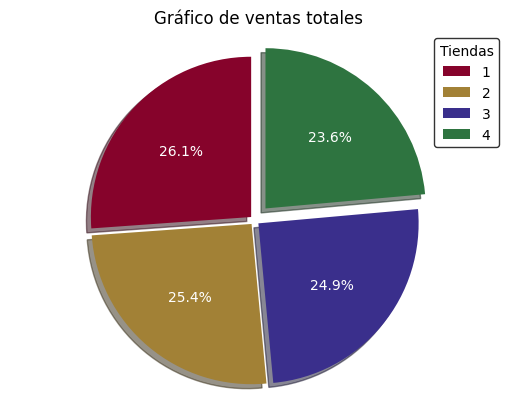

In [141]:
grafico_torta(res_analisis_fact,'Tienda', 'Ventas Totales', 'Gráfico de ventas totales', 'Tiendas')

# 2. Ventas por categoría

In [ ]:
def ventas_por_categoria(df):
    try:
        # 1. Contar la cantidad de productos vendidos por Tienda y Categoría
        conteo_ventas = df.groupby(['Tienda', 'Categoría del Producto']).size().reset_index(name='Cantidad Vendida')

        # 2. Encontrar el índice de la categoría más popular por Tienda
        indice_max_por_tienda = conteo_ventas.loc[conteo_ventas.groupby('Tienda')['Cantidad Vendida'].idxmax()]

        # 3. Renombrar la columna para mayor claridad
        categoria_popular = indice_max_por_tienda.rename(columns={'Categoría del Producto': 'Categoría Más Popular'})

        # 4. Seleccionar y mostrar las columnas relevantes
        resultado = categoria_popular[['Tienda', 'Categoría Más Popular', 'Cantidad Vendida']]

        print("La categoría más popular por tienda es:\n")
        print(resultado.to_string(index=False, justify='center'))

    except Exception as e:
        print(f"Ocurrió un error durante el análisis de ventas por categoría: {e}")

ventas_por_categoria(df_pandas)


La categoría más popular por tienda es:

Tienda Categoría Más Popular  Cantidad Vendida
  1           Muebles               465       
  2           Muebles               442       
  3           Muebles               499       
  4           Muebles               480       


# 3. Calificación promedio de la tienda


In [ ]:
def calificacion_promedio(df):
    try:
        # 1. Calcular la calificación promedio por Tienda
        calificacion_promedio = df.groupby('Tienda')['Calificación'].mean().reset_index(name='Calificación Promedio')

        # 2. Formatear la calificación promedio de cada tienda
        calificacion_promedio['Calificación Promedio'] = calificacion_promedio['Calificación Promedio'].map('{:.2f}'.format)

        print("La calificación promedio por tienda es:\n")
        print(calificacion_promedio.to_string(index=False, justify='center'))

    except Exception as e:
        print(f"Ocurrió un error durante el análisis de calificación promedio: {e}")

calificacion_promedio(df_pandas)

La calificación promedio por tienda es:

Tienda Calificación Promedio
  1             3.98        
  2             4.04        
  3             4.05        
  4             4.00        


# 4. Productos más y menos vendidos

In [ ]:
def productos_mas_vendidos(df):
    try:
        # 1. Contar la cantidad de productos vendidos por Tienda y Producto
        conteo_ventas = df.groupby(['Tienda', 'Producto']).size().reset_index(name='Cantidad Vendida')

        # 2. Encontrar el índice del producto más vendido por Tienda
        indice_max_por_tienda = conteo_ventas.loc[conteo_ventas.groupby('Tienda')['Cantidad Vendida'].idxmax()]

        # 3. Seleccionar y mostrar las columnas relevantes
        resultado = indice_max_por_tienda[['Tienda', 'Producto', 'Cantidad Vendida']]

        print("El producto más vendido por tienda es:\n")
        print(resultado.to_string(index=False, justify='center'))

    except Exception as e:
        print(f"Ocurrió un error durante el análisis de productos más vendidos: {e}")

productos_mas_vendidos(df_pandas)

El producto más vendido por tienda es:

Tienda          Producto          Cantidad Vendida
  1                      Armario         60       
  2    Iniciando en programación         65       
  3                Kit de bancas         57       
  4                     Cama box         62       


In [ ]:
def productos_menos_vendidos(df):
    try:
        # 1. Contar la cantidad de productos vendidos por Tienda y Producto
        conteo_ventas = df.groupby(['Tienda', 'Producto']).size().reset_index(name='Cantidad Vendida')

        # 2. Encontrar el índice del producto menos vendido por Tienda
        indice_min_por_tienda = conteo_ventas.loc[conteo_ventas.groupby('Tienda')['Cantidad Vendida'].idxmin()]

        # 3. Seleccionar y mostrar las columnas relevantes
        resultado = indice_min_por_tienda[['Tienda', 'Producto', 'Cantidad Vendida']]

        print("El producto menos vendido por tienda es:\n")
        print(resultado.to_string(index=False, justify='center'))

    except Exception as e:
        print(f"Ocurrió un error durante el análisis de productos más vendidos: {e}")

productos_menos_vendidos(df_pandas)

El producto menos vendido por tienda es:

Tienda          Producto          Cantidad Vendida
  1    Auriculares con micrófono         33       
  2                Juego de mesa         32       
  3      Bloques de construcción         35       
  4           Guitarra eléctrica         33       


# 5. Envío promedio por tienda

In [ ]:
def envio_promedio(df):
    try:
        # 1. Calcular el envío promedio por Tienda
        envio_promedio = df.groupby('Tienda')['Costo de envío'].mean().reset_index(name='Envío Promedio')

        # 2. Formatear la calificación promedio de cada tienda
        envio_promedio['Envío Promedio'] = envio_promedio['Envío Promedio'].map('${:,.2f}'.format)

        print("El envío promedio por tienda es:\n")
        print(envio_promedio.to_string(index=False, justify='center'))

    except Exception as e:
        print(f"Ocurrió un error durante el análisis de envío promedio: {e}")

envio_promedio(df_pandas)

El envío promedio por tienda es:

Tienda Envío Promedio
  1      $26,018.61  
  2      $25,216.24  
  3      $24,805.68  
  4      $23,459.46  


# Función para gráficos

## Gráficos

In [142]:
def grafico_barras(df,eje_x:str, eje_y:str, titulo:str, ancho_barra:float, titulo_leyenda:str):

  try:

    # Obtener las etiquetas del eje x
    x = df[eje_x]

    # Obtener los valores para las barras (ventas totales)
    y = df[eje_y]

    # Definir una lista de colores para cada barra
    colores = ['#86032b', '#a28136', '#3a2f8c', '#2e7440']

    # Crear la figura y los axes
    fig, ax = plt.subplots(figsize=(10, 6))

    # Crear la gráfica de barras en el axes
    barras = ax.bar(range(len(x)), y, color=colores, width=ancho_barra, label=x)
    for barra in barras:
        yval = barra.get_height()
        ax.text(barra.get_x() + barra.get_width()/2, yval, f'${yval:.2f}', ha='center', va='bottom')

    # Añadir etiquetas y título usando el objeto axes
    ax.set_xlabel(eje_x)
    ax.set_ylabel(eje_y)
    ax.set_title(titulo)

    # Ocultar las etiquetas del eje x y y
    ax.set_xticks([])
    ax.set_yticks([])

    # Rotar las etiquetas del eje x para mejor visualización si es necesario
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Mostrar la leyenda
    plt.legend(title=titulo_leyenda, loc='upper left', bbox_to_anchor=(1, 1), edgecolor='black')

    # Cambiar el color de fondo del área de la gráfica (axes)
    ax.set_facecolor('#dff3c0')

    # Mostrar la gráfica
    plt.show()

  except Exception as e:
        print(f"Ocurrió un error al generar el gráfico: {e}")

def grafico_dispersion(df,eje_x:str, eje_y:str, titulo:str, titulo_leyenda:str):

  try:
    # Especifica los nombres de las columnas que quieres usar
    x_columna = 'Tienda'
    y_columna = 'Ventas Totales'

    # Obtener los nombres únicos de las tiendas y asignarles códigos numéricos
    tiendas_unicas = res_analisis_fact[x_columna].unique()
    mapeo_tiendas = {tienda: i for i, tienda in enumerate(tiendas_unicas)}
    codigos_tiendas = res_analisis_fact[x_columna].map(mapeo_tiendas)

    fig, ax = plt.subplots()

    # Crear el gráfico de dispersión, mapeando el color a los códigos de las tiendas
    scatter = ax.scatter(res_analisis_fact[x_columna], res_analisis_fact[y_columna],
                      s=res_analisis_fact[x_columna] * 30,  # El tamaño basado en Ventas Totales
                      c=codigos_tiendas, cmap='plasma', alpha=0.7)

    num_filas = len(res_analisis_fact)

    for i in range(num_filas):
        ax.annotate(f'$ {res_analisis_fact[y_columna].iloc[i]:.2f}',
                    (res_analisis_fact[x_columna].iloc[i], res_analisis_fact[y_columna].iloc[i]),
                    xytext=(5, 30),  # Desplazamiento del texto
                    textcoords='offset points',
                    arrowprops=dict(facecolor='black', shrink=0.02), ha='left', va='bottom',
                    fontsize=8, bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 0.5,
                                      'edgecolor': 'none'})

    plt.title(titulo)
    plt.xlabel(x_columna)
    plt.ylabel(y_columna)

    # Ocultar las etiquetas del eje x y y (ya que 'Tienda' es categórica)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Color de fondo
    ax.set_facecolor('#c7e1ec')

    # Crear la leyenda basada en los nombres de las tiendas y los colores
    legend_handles = [plt.scatter([], [], color=plt.cm.plasma(mapeo_tiendas[tienda] / (len(tiendas_unicas) -1) if len(tiendas_unicas) > 1 else 0), label=tienda)
                      for tienda in tiendas_unicas]

    plt.legend(handles=legend_handles, title=titulo_leyenda, loc='best', bbox_to_anchor=(1, 1), edgecolor='black')

    #Mostrar grilla
    ax.grid(True, color='#0a0a0a', linestyle='-', linewidth=0.5, alpha=0.7)

    # Mostrar gráfico
    plt.tight_layout()

    #Mostrar gráfica
    plt.show()

  except Exception as e:
        print(f"Ocurrió un error al generar el gráfico: {e}")

def grafico_torta(df,categoria:str, valor:str, titulo:str, titulo_leyenda:str):
  try:
    #Obtener los datos para el gráfico
    etiquetas = res_analisis_fact[categoria]
    valores = res_analisis_fact[valor]

    #Crear el gráfico de torta
    sepracion = (0.03, 0.03, 0.03, 0.1)
    colores = ['#86032b', '#a28136', '#3a2f8c', '#2e7440']
    plt.pie(valores, labels=etiquetas, autopct='%1.1f%%', startangle=90, textprops={'color': 'white'}, explode=sepracion, colors=colores, shadow=True)

    #Crear leyenda
    plt.legend(title=titulo_leyenda, loc='best', bbox_to_anchor=(1, 1), edgecolor='black')

    #Asegurar que el círculo se dibuje como un círculo
    plt.axis('equal')

    #Añadir un título (opcional)
    plt.title(titulo)

    #Mostrar el gráfico
    plt.show()

  except Exception as e:
        print(f"Ocurrió un error al generar el gráfico: {e}")